In [1]:
import numpy as np
import pandas as pd

In [2]:
train_fname = './dataset/IMDB Dataset.csv'
df_train = pd.read_csv(train_fname)
df_train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
import matplotlib.pyplot as plt
df_train['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Text(0.5, 0, 'Sentiment')

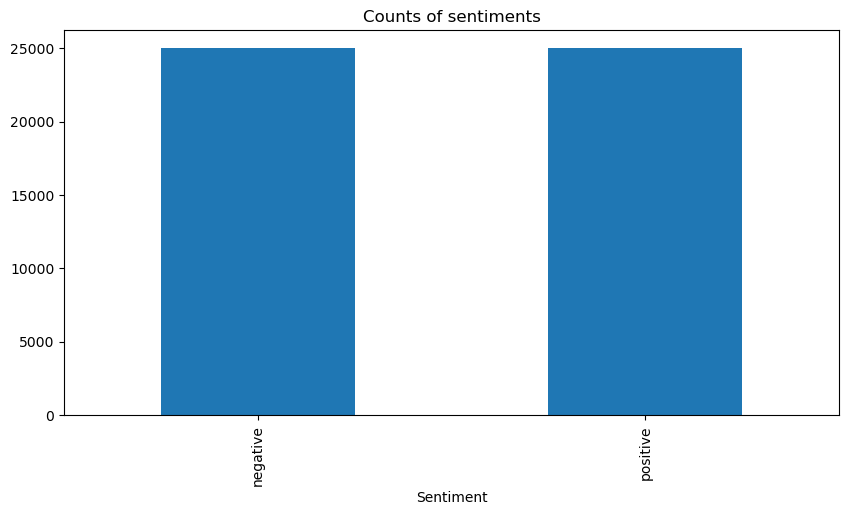

In [4]:
ax = df_train['sentiment'].value_counts().sort_index().plot(kind='bar', title='Counts of sentiments', figsize=(10, 5))
ax.set_xlabel('Sentiment')

In [5]:
import re
import nltk
import spacy
import spacy.cli
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/anhtuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anhtuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anhtuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
lemmatizer = WordNetLemmatizer()
if not spacy.util.is_package("en_core_web_sm"):
    spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

def preprocess_data(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    words = word_tokenize(text)

    filtered_words = [word for word in words if not word in stop_words and len(word) > 3]
    processed_text = ''
    for word in filtered_words:
        word = lemmatizer.lemmatize(word)
        processed_text = processed_text  + ' ' + str(word)

    doc = nlp(processed_text)
    processed_text = ''
    for token in doc:
        processed_text = processed_text  + ' ' + str(token.lemma_)

    return re.sub(r'\s+', ' ', processed_text)

In [7]:
import torch
from tqdm import tqdm
from collections import Counter
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [8]:
def get_corpus(df):
    corpus = []
    for i in tqdm(range(len(df))):
        preprocessed_text = preprocess_data(df['review'].values[i])
        corpus.append(preprocessed_text.split())
    corpus = Counter(np.hstack(corpus))
    corpus2 = sorted(corpus, key=corpus.get, reverse=True)
    corpus2 = ['<PAK>', '<UNK>'] + corpus2
    vocab_to_int = {word: idx for idx, word in enumerate(corpus2, 1)}
    phrase_to_int = []
    for i in tqdm(range(len(df))):
        preprocessed_text = preprocess_data(df['review'].values[i])
        phrase_to_int.append([vocab_to_int[word] for word in preprocessed_text.split()])
    return corpus, vocab_to_int, phrase_to_int

In [9]:
corpus, vocab_to_int, phrase_to_int = get_corpus(df_train)

100%|██████████| 50000/50000 [15:42<00:00, 53.03it/s]


In [10]:
def pad_sequences(phrase_to_int, seq_length):
    pad_sequences = np.zeros((len(phrase_to_int), seq_length), dtype=int)
    for idx,row in tqdm(enumerate(phrase_to_int), total=len(phrase_to_int)):
        pad_sequences[idx, :len(row)] = np.array(row)[:seq_length]
    return pad_sequences

In [11]:
seq_length = 300
padded_sequences = pad_sequences(phrase_to_int, seq_length)

100%|██████████| 50000/50000 [00:00<00:00, 111857.65it/s]


In [12]:
labels = df_train['sentiment'].tolist()
labels = [1 if label == "positive" else 0 for label in labels]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [14]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_test)
y_val_tensor = torch.tensor(y_test)

In [15]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 50
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [17]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) 

Sample input size:  torch.Size([50, 300])
Sample input: 
 tensor([[2538, 1173,  187,  ...,    0,    0,    0],
        [  26,    9,    4,  ...,    0,    0,    0],
        [  21,  751, 7093,  ...,    0,    0,    0],
        ...,
        [1267,  210,  526,  ...,    0,    0,    0],
        [ 555,   80,  331,  ...,    0,    0,    0],
        [ 192,  511, 1844,  ...,    0,    0,    0]])

Sample label size:  torch.Size([50])


In [18]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)

        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]

        return sig_out, hidden


    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))

        return hidden

In [19]:
n_vocab = len(vocab_to_int) + 1
n_embed = 400
n_hidden = 256
n_output = 1
n_layers = 2
n_epochs = 7
learning_rate = 0.001

In [20]:
net = SentimentRNN(n_vocab, n_output, n_embed, n_hidden, n_layers)
print(net)

SentimentRNN(
  (embedding): Embedding(81383, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [21]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [22]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%d%m%y_%H%M%S")
model_name = "./dataset/model_{}.pth".format(current_time)
print(model_name)

./dataset/model_030424_110721.pth


In [ ]:
counter = 0
print_every = 100
clip = 5
min_val_loss = float('inf')

net.to(device)
net.train()

for e in range(n_epochs):
    h = net.init_hidden(batch_size)

    for inputs, labels in train_loader:
        counter += 1

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        net.zero_grad()

        output, h = net(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        if counter % print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])

                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, n_epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

            if np.mean(val_losses) < min_val_loss:
                print("Saving model...")
                torch.save(net.state_dict(), model_name)
                min_val_loss = np.mean(val_losses)

In [23]:
def predict(net, sentence, vocab):
  text = preprocess_data(sentence)
  words = word_tokenize(text)
  text_ints = []
  text_ints.append([vocab[word] for word in words])
  padded_text = pad_sequences(text_ints, seq_length)

  net.eval()

  text_tensor = torch.from_numpy(padded_text)
  batch_size = text_tensor.size(0)
  h = net.init_hidden(batch_size)
  text_tensor = text_tensor.to(device)

  output, h = net(text_tensor, h)
  pred = torch.round(output.squeeze())
  print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
  if(pred.item()==1):
    print('Positive review detected!')
  else:
    print('Negative review detected!')

In [25]:
sentence = 'This movie is very great'
predict(net, sentence, vocab_to_int)

100%|██████████| 1/1 [00:00<00:00, 9915.61it/s]

Prediction value, pre-rounding: 0.503560
Positive review detected!
